In [116]:
#!pip install pmdarima

In [117]:
from pmdarima.arima import auto_arima, ADFTest
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

In [118]:
data = pd.read_csv("/content/dataset.csv", header=0)
data.head()

,year,area,co2,temp
0,1986.0,71948.360,11.742280,-2.8
1,1988.0,71998.671,14.216778,-2.7
2,1990.0,71960.295,15.493280,-3.7
3,1992.0,71902.669,18.458245,-3.9
4,1994.0,71902.299,17.701824,-3.2


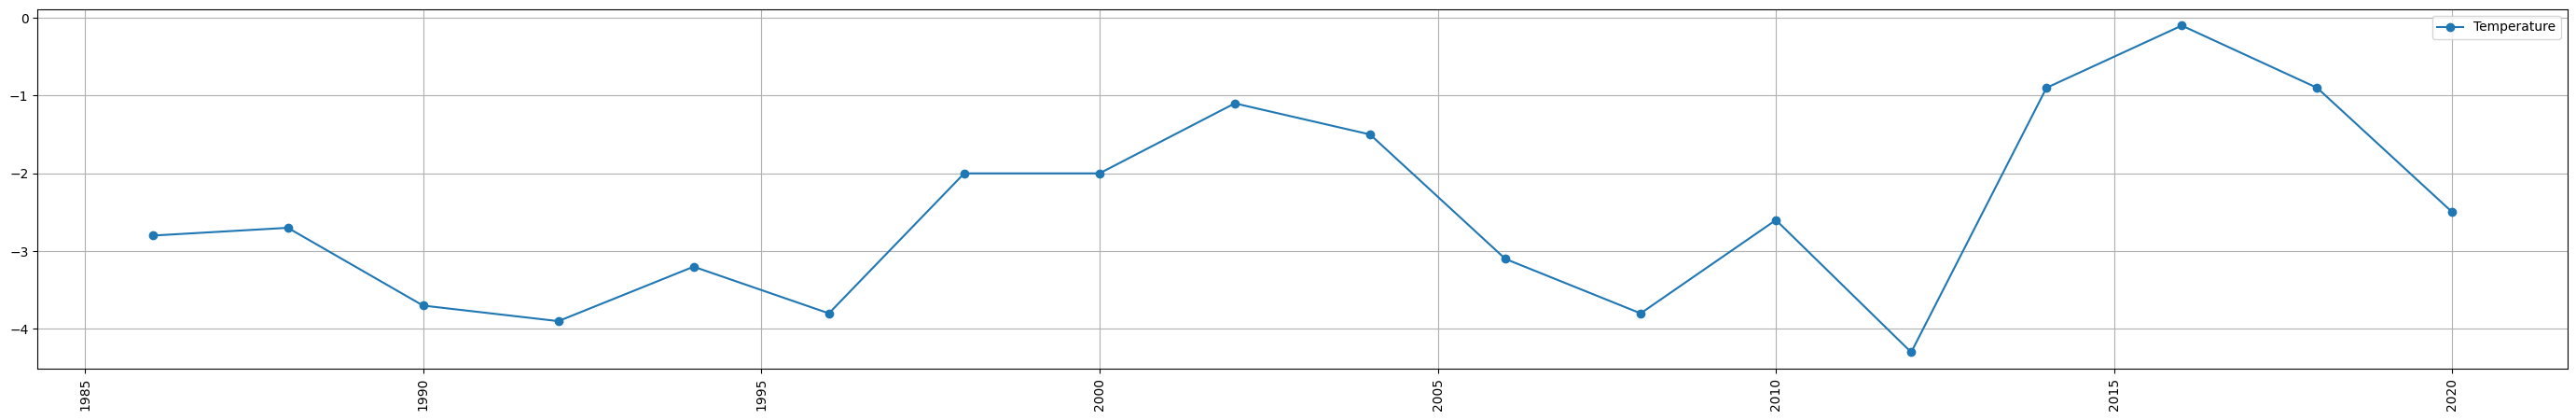

In [119]:
plt.figure(figsize=(35,5))
plt.grid()
plt.plot(data['year'], data['temp'], marker='o', label='Temperature')
plt.xticks(rotation=90)
plt.legend()
plt.show()

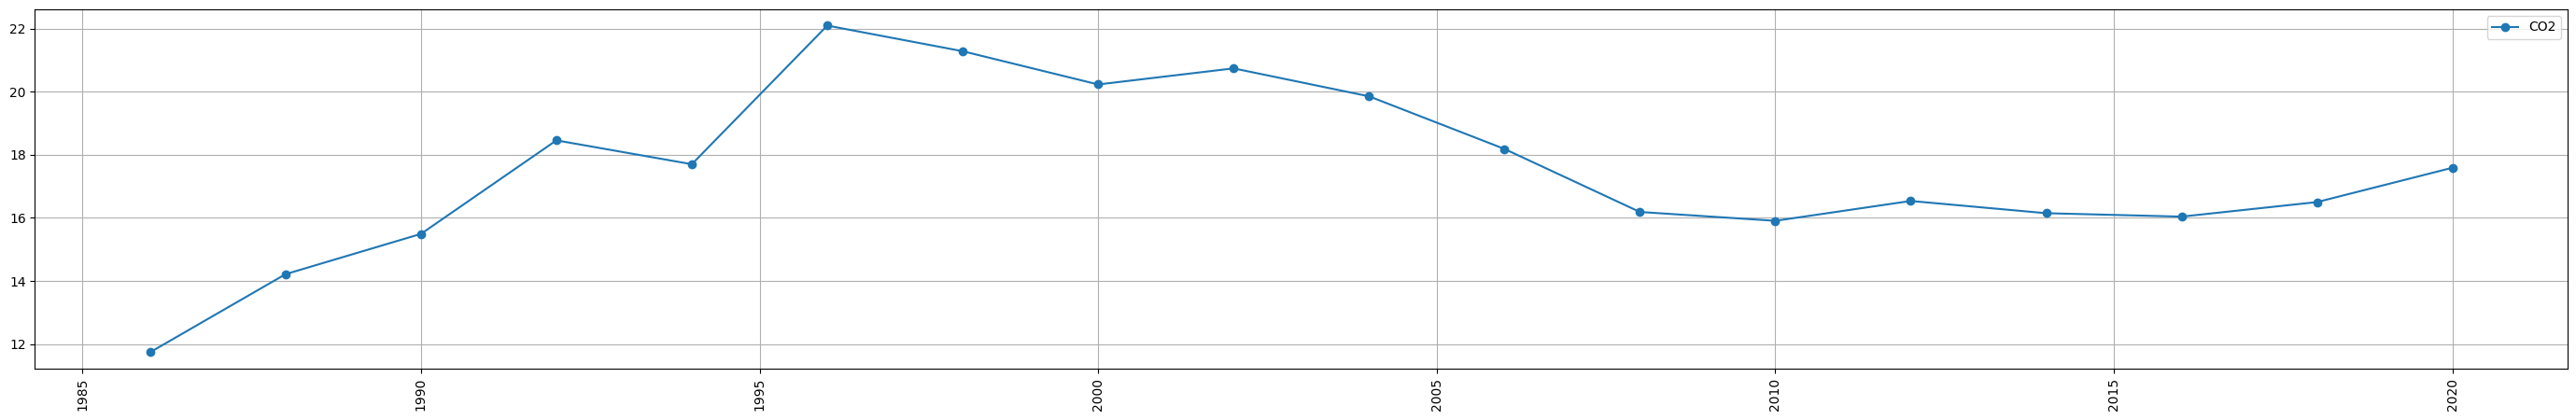

In [120]:
plt.figure(figsize=(35,5))
plt.grid()
plt.plot(data['year'], data['co2'], marker='o', label='CO2')
plt.xticks(rotation=90)
plt.legend()
plt.show()

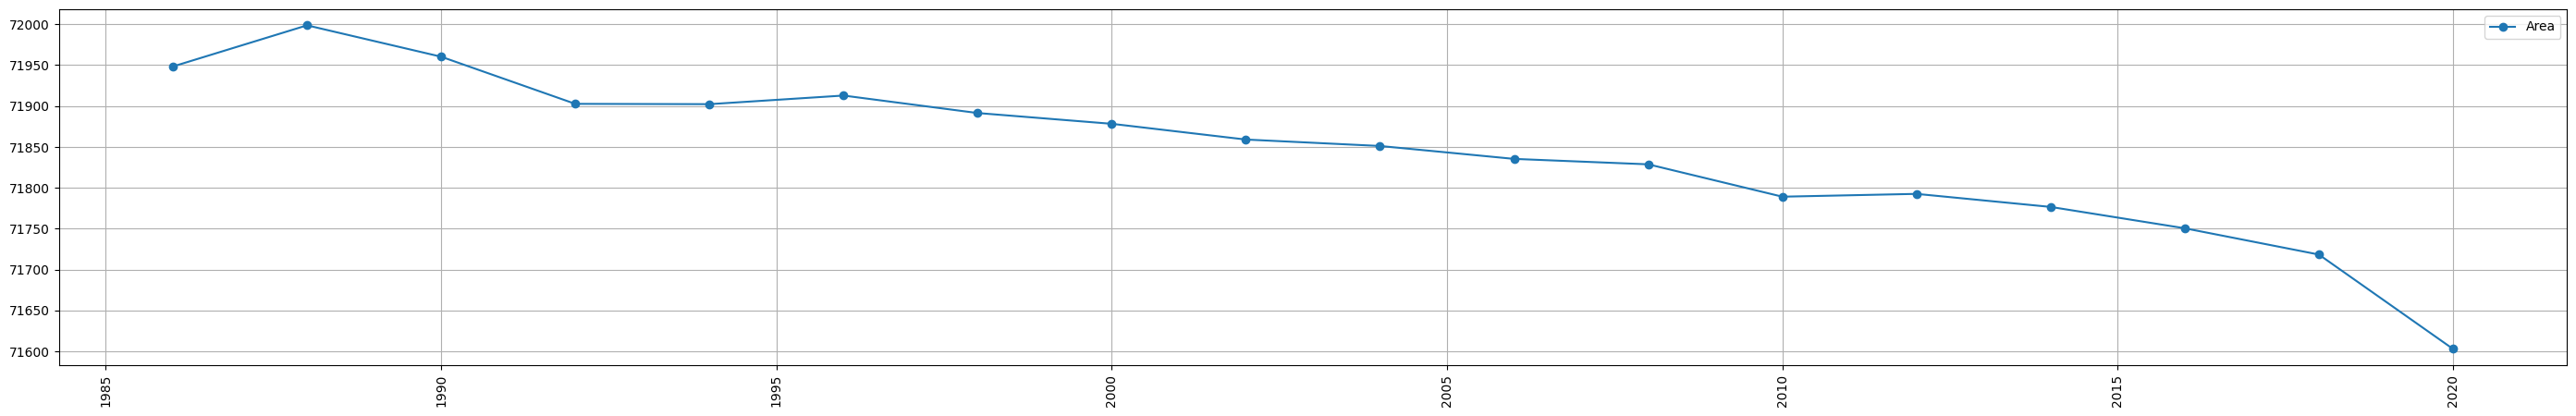

In [121]:
plt.figure(figsize=(35,5))
plt.grid()
plt.plot(data['year'],data['area'], marker='o', label='Area')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [122]:
train_size = int(len(data)*0.8)
trainset = data[:train_size]
y_train = trainset["area"]
X_train = trainset.drop("area", axis=1)
testset = data[train_size:]
y_test = testset["area"]
X_test = testset.drop("area", axis=1)

In [123]:
arima_model = auto_arima(X=X_train, y=y_train, start_p=0, d=1, start_q=0,
                         max_p=5, max_d=5, max_q=5,start_P=0, D=1, start_Q=0,
                         max_P=5, max_D=5, max_Q=5, m=1,seasonal=False,
                         error_action='warn', trace=True,
                         suppress_warnings=True,
                         stepwise=True, random_state=20, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=130.692, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=127.236, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=128.692, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=121.152, Time=0.33 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=126.429, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=122.756, Time=0.14 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 2.373 seconds


In [124]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   14
Model:               SARIMAX(2, 1, 0)   Log Likelihood                 -53.576
Date:                Fri, 22 Dec 2023   AIC                            121.152
Time:                        18:23:15   BIC                            125.106
Sample:                             0   HQIC                           120.339
                                 - 14                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    278.3708    793.519      0.351      0.726   -1276.897    1833.639
year        -124.7823    338.563     -0.369      0.712    -788.354     538.789
co2            0.6274      3.409      0.184      0.854      -6.054       7.309
temp          -9.0022      7.335     -1.227      0.220     -23.378       5.373
ar.L1          0.3547      0.320      1.110      0.267      -0.272       0.981
ar.L2         -0.5185      0.305     -1.698      0.090      -1.117       0.080
sigma2       255.6125    236.107      1.083      0.279    -207.148     718.373
===================================================================================
Ljung-Box (L1) (Q):                   1.37   Jarque-Bera (JB):                 0.22
Prob(Q):                              0.24   Prob(JB):                         0.90
Heteroskedasticity (H):               1.13   Skew:                            -0.25
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [125]:
prediction = pd.DataFrame(arima_model.predict(X=X_test, n_periods=len(testset)),
                          index=X_test.index)
prediction.columns = ["predicted area"]
mse = mean_squared_error(testset['area'], prediction)
print("RMSE", (mse)**0.5)

RMSE 70.93668423102393


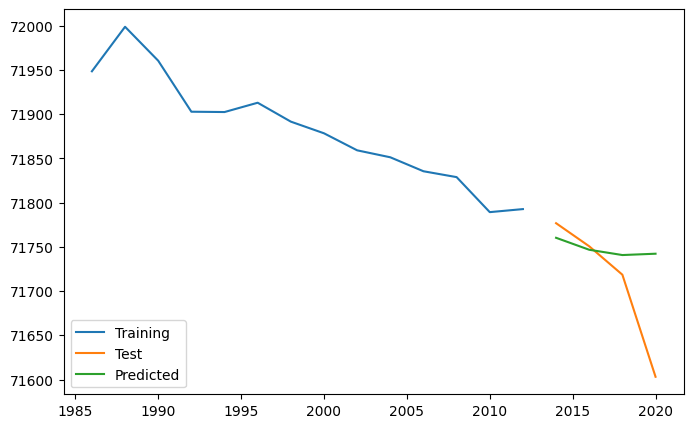

In [126]:
plt.figure(figsize=(8,5))
plt.plot(data['year'][:train_size], y_train, label="Training")
plt.plot(data['year'][train_size:], y_test, label="Test")
plt.plot(data['year'][train_size:], prediction, label="Predicted")
plt.legend(loc="lower left")
plt.show()

In [127]:
temp_values_test = [-2.5, -2, -3, -1, 2, 2, 1, 3, -4, 5]
co2_values_test = [17, 12, 13, 14, 15, 9, 10, 11, 12, 15]
years = [2021+i for i in range(10)]

test_df = pd.DataFrame({'year': years,
                        'co2': co2_values_test,
                        'temp': temp_values_test})
test_df
predicted_area = pd.DataFrame({'predicted_area': arima_model.predict(n_periods=10,X=test_df)})

predicted_area.reset_index(drop= True , inplace= True)
predicted_result = pd.concat([test_df, predicted_area], axis=1)
predicted_result

,year,co2,temp,predicted_area
0,2021,17,-2.5,70901.628953
1,2022,12,-2.0,71012.511396
2,2023,13,-3.0,71133.465552
3,2024,14,-1.0,71227.285152
4,2025,15,2.0,71315.788182
5,2026,9,2.0,71428.279719
6,2027,10,1.0,71552.741749
7,2028,11,3.0,71648.979868
8,2029,12,-4.0,71826.544224
9,2030,15,5.0,71862.067750


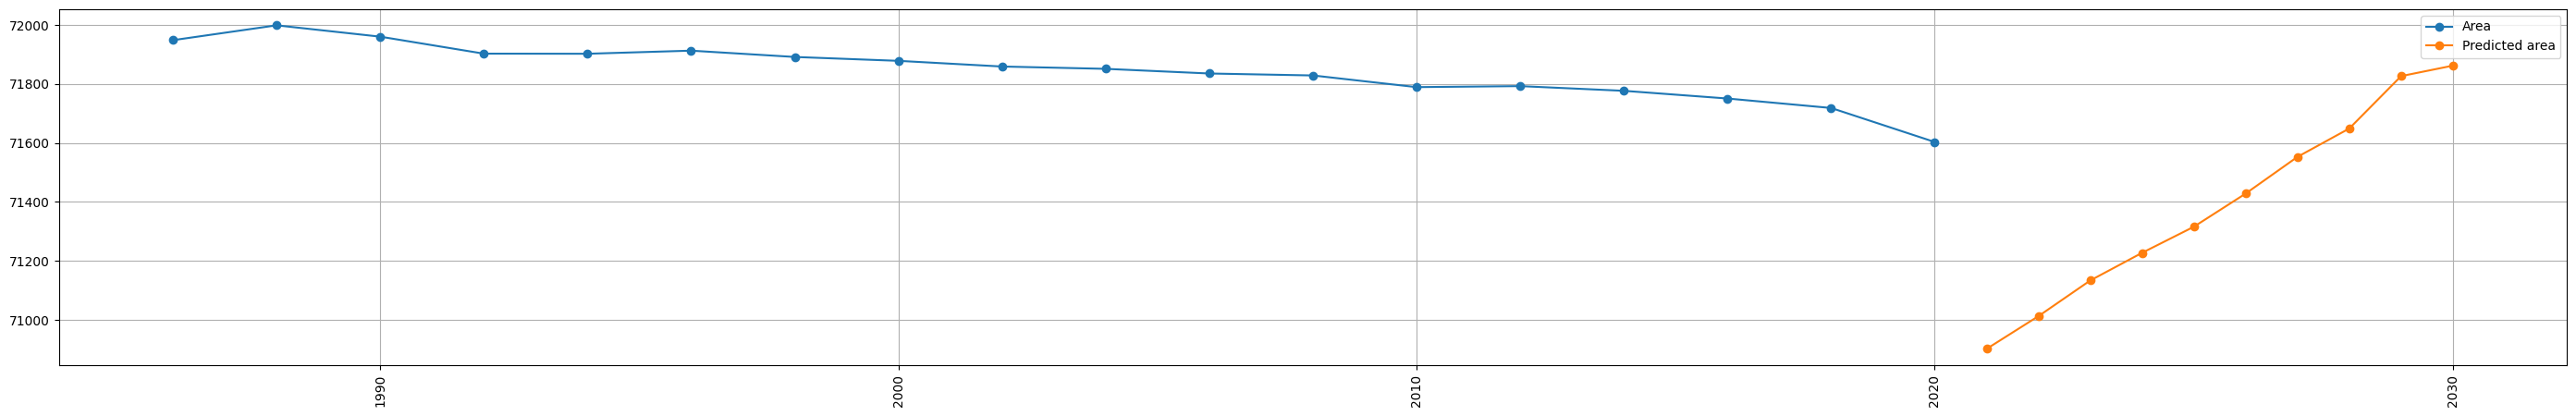

In [128]:
plt.figure(figsize=(35,5))
plt.grid()
plt.plot(data['year'], data['area'], marker='o', label='Area')
plt.plot(years, predicted_area, marker='o', label='Predicted area')
plt.xticks(rotation=90)
plt.legend()
plt.show()